In [76]:
pip install PyWavelets

In [77]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [78]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

 #### Preprocessing: Detect face and eyes

In [79]:
img = cv2.imread('./images_dataset/maria_sharapova/95349717081091468_hv3jryev_f.jpg')
img.shape

(877, 584, 3)

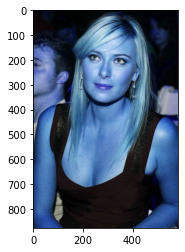

In [80]:
plt.imshow(img)

In [81]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(877, 584)

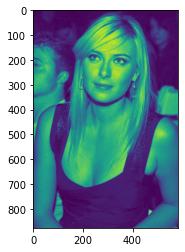

In [82]:
plt.imshow(gray)

In [83]:
gray

array([[22, 16,  8, ...,  9, 12, 13],
       [23, 16,  8, ..., 10, 12, 13],
       [23, 17,  9, ..., 10, 12, 13],
       ...,
       [35, 37, 40, ..., 19,  7,  4],
       [36, 37, 40, ..., 51, 20,  5],
       [36, 36, 39, ..., 86, 52, 34]], dtype=uint8)

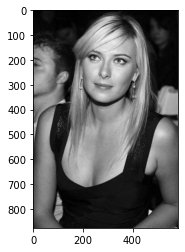

In [84]:
plt.imshow(gray, cmap='gray')

In [85]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[162,  92, 273, 273]], dtype=int32)

In [86]:
(x,y,w,h) = faces[0]
x,y,w,h

(162, 92, 273, 273)

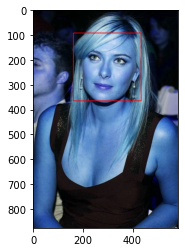

In [87]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

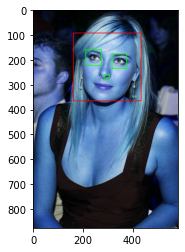

In [88]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

#### Preprocessing: Crop the facial region of the image

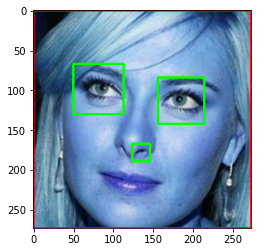

In [89]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [90]:
cropped_img = np.array(roi_color)
cropped_img.shape

(273, 273, 3)

#### Preprocessing: Use wavelet transform as a feature for traning our model

In [91]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

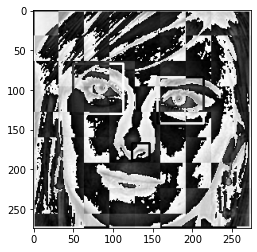

In [92]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [93]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

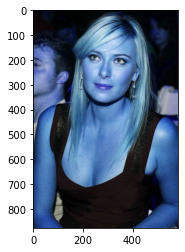

In [94]:
original_image = cv2.imread('./images_dataset/maria_sharapova/95349717081091468_hv3jryev_f.jpg')
plt.imshow(original_image)

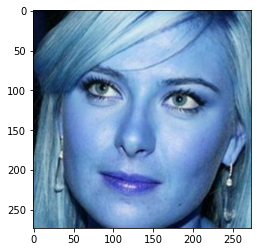

In [95]:
cropped_image = get_cropped_image_if_2_eyes('./images_dataset/maria_sharapova/95349717081091468_hv3jryev_f.jpg')
plt.imshow(cropped_image)

In below image face is not very clear and it doesn't have two eyes clearly visible

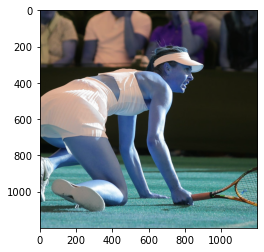

In [96]:
org_image_obstructed = cv2.imread('./images_dataset/maria_sharapova/2900.jpg')
plt.imshow(org_image_obstructed)

In [97]:

cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./images_dataset/maria_sharapova/2900.jpg')
cropped_image_no_2_eyes

Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [98]:
path_to_data = "./images_dataset/"
path_to_cr_data = "./images_dataset/cropped/"

In [99]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [100]:
img_dirs

['./images_dataset/cropped',
 './images_dataset/lionel_messi',
 './images_dataset/maria_sharapova',
 './images_dataset/roger_federer',
 './images_dataset/serena_williams',
 './images_dataset/virat_kohli']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [101]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [102]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
lionel_messi
Generating cropped images in folder:  ./images_dataset/cropped/lionel_messi
maria_sharapova
Generating cropped images in folder:  ./images_dataset/cropped/maria_sharapova
roger_federer
Generating cropped images in folder:  ./images_dataset/cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./images_dataset/cropped/serena_williams
virat_kohli
Generating cropped images in folder:  ./images_dataset/cropped/virat_kohli


#### Now you should have cropped folder under datasets folder that contains cropped images
Manually examine cropped folder and delete any unwanted images

In [110]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./images_dataset/cropped/lionel_messi\\lionel_messi1.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi10.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi11.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi13.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi14.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi15.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi16.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi17.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi18.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi19.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi2.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi20.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi21.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi22.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi23.png',
  './images_dataset/cropped/lionel_messi\

In [121]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [123]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [124]:
len(X[0])

4096

In [125]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [126]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(167, 4096)

In [116]:
y[0]

0

#### Data cleaning process is done. Now we are ready to train our model
We will use SVM with rbf kernel tuned with heuristic finetuning

In [127]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [128]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7619047619047619

In [129]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.89      0.80      0.84        10
           2       0.57      0.57      0.57         7
           3       0.60      0.86      0.71         7
           4       0.90      0.82      0.86        11

    accuracy                           0.76        42
   macro avg       0.76      0.75      0.75        42
weighted avg       0.78      0.76      0.77        42



#### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [130]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [131]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [132]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.880,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.688,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.888,{'logisticregression__C': 1}


In [133]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [134]:
best_estimators['svm'].score(X_test,y_test)

0.7619047619047619

In [135]:
best_estimators['random_forest'].score(X_test,y_test)

0.6666666666666666

In [136]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8095238095238095

In [137]:
best_clf = best_estimators['logistic_regression']

In [138]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 1, 0, 1, 0],
       [0, 8, 0, 1, 1],
       [0, 0, 6, 1, 0],
       [0, 0, 0, 7, 0],
       [1, 1, 0, 1, 8]], dtype=int64)

Text(69.0, 0.5, 'Truth')

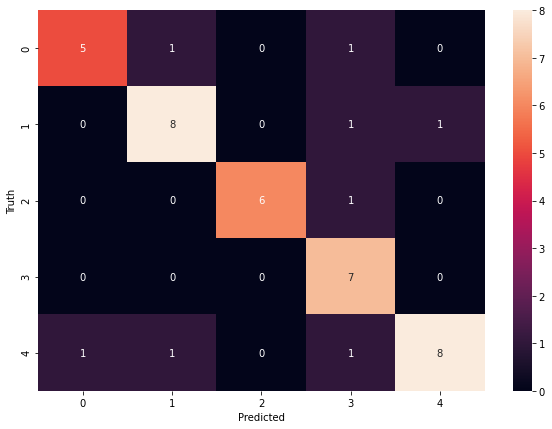

In [139]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [140]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [141]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'model.pkl')

['model.pkl']

In [142]:
import json
# Save class dictionary
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))